In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!curl https://camo.githubusercontent.com/336f0b43530f0123ea4cc25e8cedfb8e89b33f446ee4ecede0bcd38f1598c1ae/68747470733a2f2f7261772e6769746875622e636f6d2f6d696b6f6c616c7973656e6b6f2f6c656e612f6d61737465722f6c656e612e706e67 --output lena.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  462k  100  462k    0     0   587k      0 --:--:-- --:--:-- --:--:--  587k


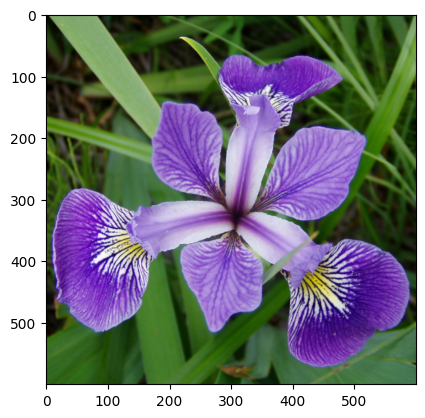

In [ ]:
lena = cv2.imread("no_index/setal.jpg")[::, ::, ::-1]
plt.imshow(lena)

In [147]:
def clip_histogram(histogram, clip_value):
    excess = histogram - clip_value
    excess[excess < 0] = 0
    total_excess = excess.sum()
    hist_clipped = np.minimum(histogram, clip_value)
    redist = total_excess // 256
    hist_clipped += redist
    remainder = total_excess % 256
    for i in range(256):
        if remainder > 0:
            hist_clipped[i] += 1
            remainder -= 1
        else:
            break
    
    return hist_clipped


def get_histogram_and_cdf(img, cdf_magnitude = None, clip_value = None):
    histogram, _ = np.histogram(img.ravel(), bins=256)
    
    if clip_value is not None:
        histogram = clip_histogram(histogram, clip_value)
    
    cdf = histogram.cumsum()
    cdf_normalized = cdf * histogram.max() / cdf.max()
    if cdf_magnitude:
        cdf_normalized = cdf_normalized * cdf_magnitude / histogram.max()
    return histogram, cdf_normalized


def plot_channel_histogram(img):
    histogram, cdf = get_histogram_and_cdf(img.ravel())
    bins = np.arange(0, 256)
    
    plt.figure(figsize=(6, 12))
    fig, axis = plt.subplots(1, 1)
    axis.plot(bins, histogram, color='b')
    axis.plot(bins, cdf, color='r')
    plt.xlim([0, 256])
    plt.legend(('histogram','cdf'), loc = 'upper left')


def equalize_hist(img):
    hist, cdf = get_histogram_and_cdf(img.ravel(), cdf_magnitude=1.0)
    output = cdf[img.ravel()]
    return output

In [260]:
def compute_mappings(image, n_rows, n_cols, cell_h, cell_w, clip_value):
    mappings = [
        [None for _ in range(n_cols)]
        for _ in range(n_rows)
    ]
    
    for i in range(n_rows):
        for j in range(n_cols):
            r0, r1 = i * cell_h, min((i + 1) * cell_h, image.shape[0])
            c0, c1 = j * cell_w, min((j + 1) * cell_w, image.shape[0])
            block = image[r0:r1, c0:c1]
            hist, cdf = get_histogram_and_cdf(block, 255, clip_value)
            mappings[i][j] = cdf
    
    return mappings


def interpolation_indices(coord, cell_size, max_index):
    coord_center = coord + 0.5
    f = coord_center / cell_size # if above 1.5 then look at next block, if below then previous block
    f = f - 0.5
    i0 = int(np.floor(f))
    i1 = min(i0 + 1, max_index - 1)
    
    weight = f - i0 if 0 <= i0 <= max_index else 0 # take only fractional part

    return max(0, i0), i1, weight


def apply_interpolation(image, mappings, n_rows, n_cols, cell_h, cell_w):
    height, width = image.shape[:2]
    output = np.zeros_like(image, dtype=np.uint8)
    
    for y in range(height):
        i0, i1, y_weight = interpolation_indices(y, cell_h, n_rows)
        for x in range(width):
            j0, j1, x_weight = interpolation_indices(x, cell_w, n_cols)
            
            intensity = image[y, x]
            val_tl, val_tr = mappings[i0][j0][intensity], mappings[i0][j1][intensity]
            val_bl, val_br = mappings[i1][j0][intensity], mappings[i1][j1][intensity]
            
            top = val_tl * (1 - x_weight) + val_tr * x_weight
            bottom = val_bl * (1 - x_weight) + val_br * x_weight
            
            output[y, x] = int(np.round(top * (1 - y_weight) + bottom * y_weight))
    
    return output


def clahe(img, grid_size=(8, 8), clip_value=10):
    r, g, b = np.unstack(img, axis=-1)
    height, width = img.shape[:2]
    n_rows, n_cols = grid_size
    cell_h, cell_w = height // n_rows, width // n_cols
    
    output_channels = []
    for channel in (r, g, b):
        mappings = compute_mappings(channel, n_rows, n_cols, cell_h, cell_w, clip_value)
        out = apply_interpolation(channel, mappings, n_rows, n_cols, cell_h, cell_w)
        output_channels.append(out)
    
    return np.stack(output_channels, axis=-1)

<Figure size 600x1200 with 0 Axes>

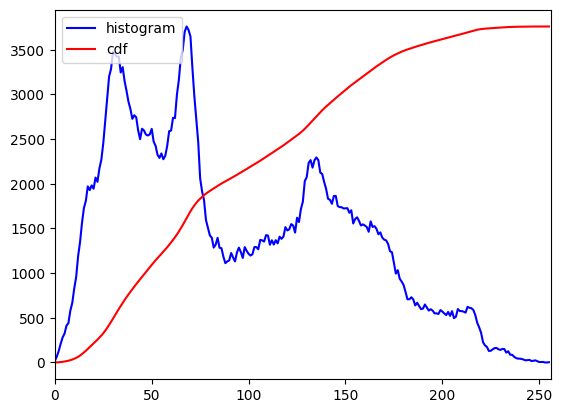

In [261]:
r, g, b = np.unstack(lena, axis=-1)
plot_channel_histogram(r)

<Figure size 600x1200 with 0 Axes>

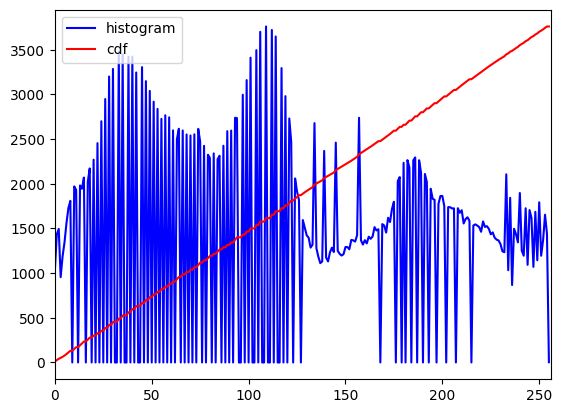

In [262]:
new_r = (equalize_hist(r).reshape(*r.shape) * 255).astype('uint8')
plot_channel_histogram(new_r)

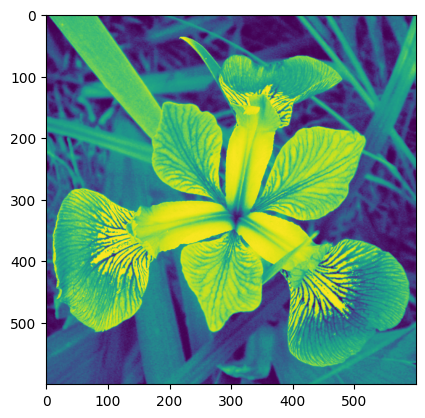

In [218]:
plt.imshow(new_r)

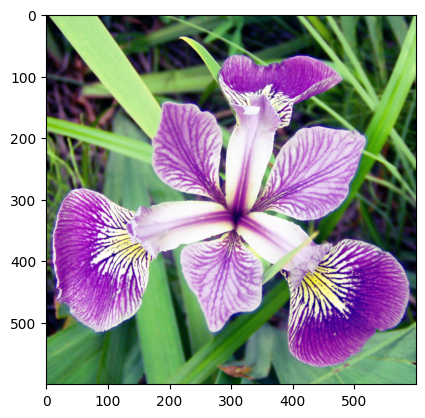

In [219]:
new_r = (equalize_hist(r).reshape(*r.shape) * 255).astype('uint8')
new_g = (equalize_hist(g).reshape(*g.shape) * 255).astype('uint8')
new_b = (equalize_hist(b).reshape(*b.shape) * 255).astype('uint8')
new_image = np.stack((new_r, new_g, new_b), axis=-1)
plt.imshow(new_image)

# Blocking-Pattern

In [220]:
def blocking_equalization(img, grid_size: int = 4):
    r, g, b = np.unstack(img, axis=-1)
    channels = []
    for channel in (r, g, b):
        height, width = img.shape[1] // grid_size, img.shape[0] // grid_size
        img_intensities = np.zeros_like(r)
        for step_height in range(grid_size):
            for step_width in range(grid_size):
                vertical_slice = slice(height * step_height, height * (1 + step_height) if step_height < grid_size - 1 else None)
                horizontal_slice = slice(width * step_width, width * (1 + step_width) if step_width < grid_size - 1 else None)
                img_intensities[vertical_slice, horizontal_slice] = (equalize_hist(channel[vertical_slice, horizontal_slice]) * 255).reshape(height, width)
        
        channels.append(img_intensities)
        
    return np.stack(channels, axis=-1)

In [221]:
lena_blocked = blocking_equalization(lena)
# plt.imshow(lena_blocked)
lena_blocked.shape

(600, 600, 3)

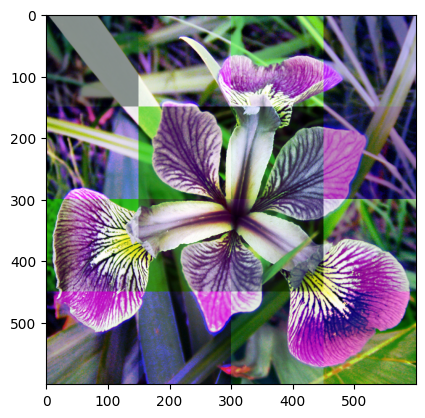

In [222]:
plt.imshow(lena_blocked)

# CLAHE

In [289]:
lena_clahe = clahe(lena, grid_size=(8,8), clip_value=100)

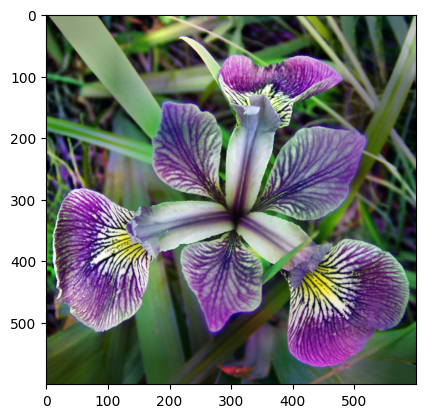

In [290]:
plt.imshow(lena_clahe)

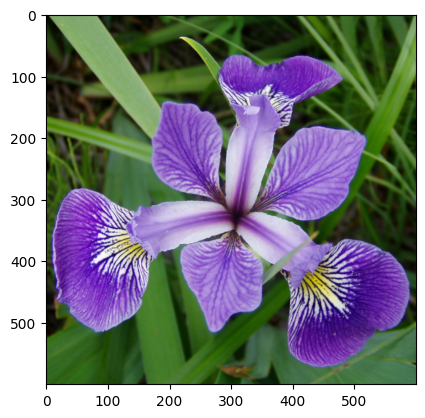

In [291]:
plt.imshow(lena)

<Figure size 600x1200 with 0 Axes>

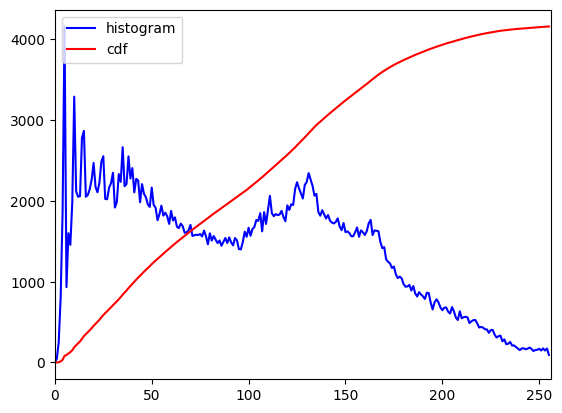

In [292]:
plot_channel_histogram(lena_clahe[:,:, 2])

<Figure size 600x1200 with 0 Axes>

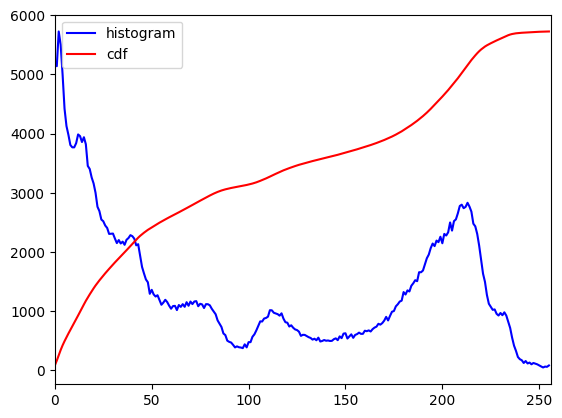

In [293]:
plot_channel_histogram(lena[:,:, 2])